## Changing training paradigm to create a velocity corrector

In [ ]:
# How they are created from high-fidelity data:
    # before:
        # X_train: mean pooling, then Nearest Neighbours interpolation
        # Y_train: n/a
    # now: 
        # X_train: mean pooling
        # Y_train: sampling (reduces size to network input size)

In [2]:
#imports
import jax
import jax.numpy as jnp

from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils

import haiku as hk
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module
from diego_preprocessing import *
from diego_train_functions import *

import matplotlib.pyplot as plt
import seaborn

import time

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [7]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = jnp.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
    ])
    high_def.append(this_time)

In [8]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 50
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


Step = 50
Training dataset shape: 
	(173, 256, 64, 2)


In [9]:
originalMax = np.max(high_def)
originalMin = (np.min(high_def))
print(originalMin,originalMax)

-0.7672701 1.0142457


In [10]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4


%time X_dataset = creatingDataset(high_def,mean_pooling,factor)
%time Y_dataset = creatingDataset(high_def,sampling,factor)

X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

CPU times: user 4.02 s, sys: 3.12 ms, total: 4.02 s
Wall time: 4.03 s
CPU times: user 373 ms, sys: 94 µs, total: 373 ms
Wall time: 375 ms


In [11]:
printAllShapes(X_train,Y_train, X_test,Y_test)

(138, 64, 16, 2)
(138, 64, 16, 2)
(35, 64, 16, 2)
(35, 64, 16, 2)


## Defining model shape

In [ ]:
tower_module = towers.forward_tower_factory #add scaling here

In [11]:
num_output_channels = 2
# spatial_size = 17
ndim = 2
input_channels = 2

rng_key = jax.random.PRNGKey(42)


forward_pass = forward_pass_module(num_output_channels = num_output_channels, 
                                    ndim = ndim,
                                    tower_module = tower_module)
                                

forward_pass = hk.without_apply_rng(hk.transform(forward_pass))

## Training model

In [ ]:
epochs = 100
learning_rates = staggeredLearningRate((100,0.001))
%time losses,val_losses,params = train(X_train,Y_train,X_test,Y_test,rng_key,input_channels,epochs,learning_rates=learning_rates,params=None,forward_pass=forward_pass)

Shapes of all datasets
(138, 64, 16, 2)
(138, 64, 16, 2)
(35, 64, 16, 2)
(35, 64, 16, 2)


Epoch 10/100
	mse : 0.051180		val mse : 0.050797	Estimated end time: 19:26:34


Epoch 20/100
	mse : 0.050656		val mse : 0.050285	Estimated end time: 19:26:27


Epoch 30/100
	mse : 0.050146		val mse : 0.049787	Estimated end time: 19:26:25


Epoch 40/100
	mse : 0.049651		val mse : 0.049303	Estimated end time: 19:26:24


Epoch 50/100
	mse : 0.049170		val mse : 0.048832	Estimated end time: 19:26:24


Epoch 60/100
	mse : 0.048701		val mse : 0.048374	Estimated end time: 19:26:23


Epoch 70/100
	mse : 0.048245		val mse : 0.047929	Estimated end time: 19:26:23




In [14]:
step = 1

plt.plot(losses[::step], label="training")
plt.plot(val_losses[::step],label="validation")
plt.ylabel("mse")
plt.xlabel("epochs")
# plt.yscale("log")
plt.legend()

NameError: name 'losses' is not defined

## Saving model

In [173]:
toSave = SaveObject()
toSave.save_params(params)
toSave.save_forward_pass_params(num_output_channels,ndim,tower_module)

In [31]:
save_path = "./../models/velocity_correctors/second_new_paradigm.pickle"

In [175]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [32]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    loaded.make_forward_pass()
    loaded.preprocess()

## Predicting with loaded model

In [177]:
num =  11 #int(np.random.rand()*np.shape(X_test)[0]//1)
vel = 0      # 0 is u, 1 is v

pred = loaded.forward_pass.apply(loaded.params,X_test[num])

In [178]:
def vorticity(u,v):
    #dvdx - dudy
    return np.gradient(v,axis = 0) -np.gradient(u,axis = 1)

In [179]:
np.shape(pred)

(64, 16, 2)

In [180]:
pred = loaded.forward_pass.apply(loaded.params,X_test[num])
np.shape(pred)

vel = 1 #0 = u, 1 = v


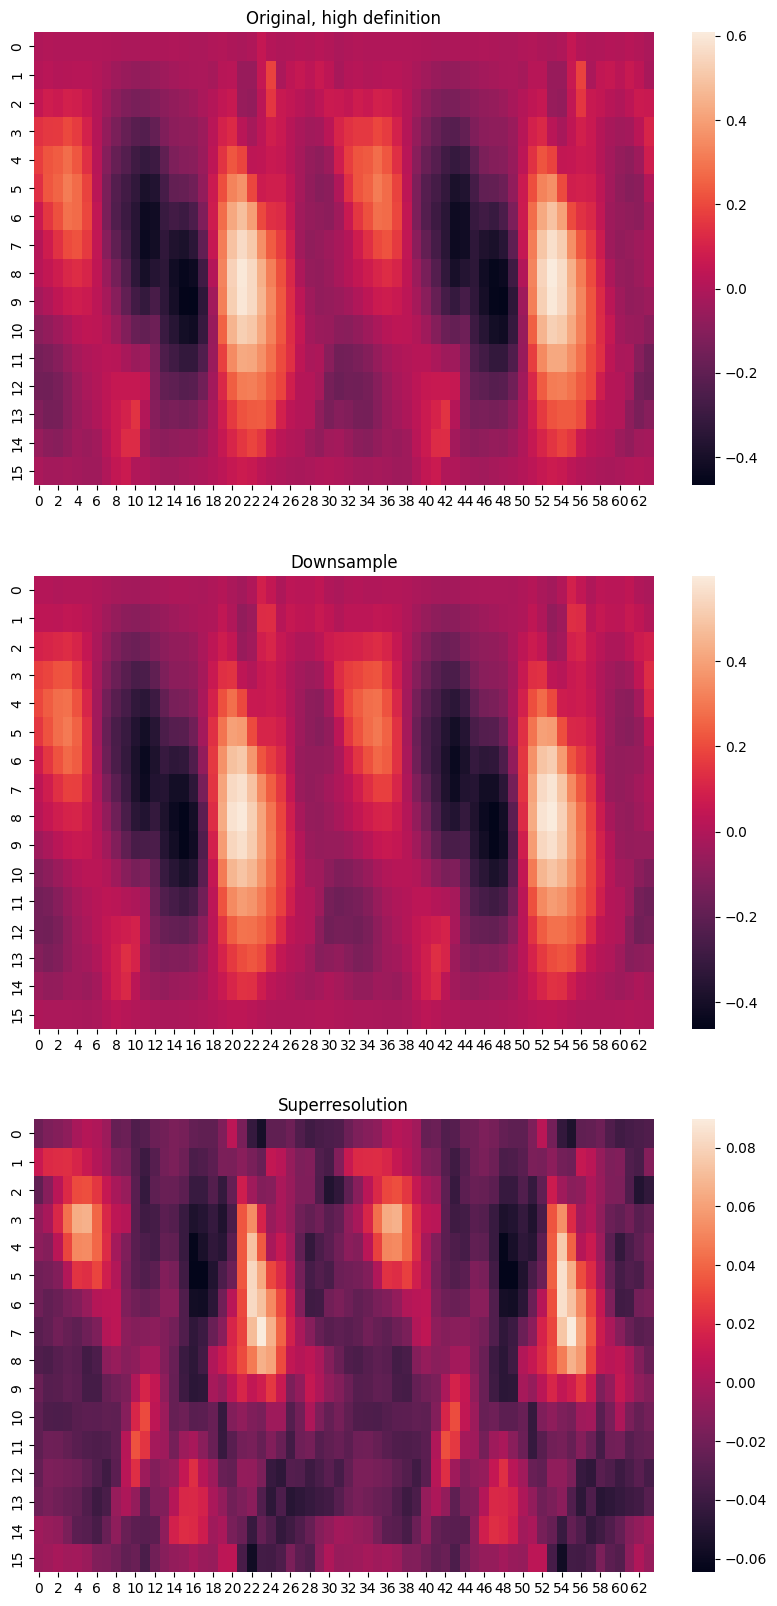

In [181]:
fig, axs = plt.subplots(3,1, facecolor='w', edgecolor='k',figsize=(10,20))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num][:,:,vel].T,ax = axs[0])
axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(X_test[num][:,:,vel].T,ax = axs[1])
axs[1].title.set_text("Downsample")
im = seaborn.heatmap(pred[:,:,vel].T,ax = axs[2])
axs[2].title.set_text("Superresolution")